# Denver 2016 Bike Share Multi-Class Classification Modeling

## 1. Introduction

The data exploration performed on the Denver Trips dataset indicates weather variables have a significant impact on the number of checkouts. This section will focus on investigating the use of various classification models on the Trips data when combined with weather variables.

In [1]:
# Import necessary libraries and functions that are needed for the modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import seaborn as sns
%matplotlib inline

In [2]:
# taken from Brandon Rhodes's Pandas Tutorial (https://github.com/brandon-rhodes)
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
dF = pd.read_csv("data/2016_Denver_Bike_Trip_ML_Data.gz", dtype = {'Bike_Number' : object}, compression="gzip")

In [4]:
dF.shape

(402965, 14)

In [5]:
dF.head(1)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Hour,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Trip_Distance,Checkout_WeekDay,Checkout_Month
0,Denver B-cycle,1052163,24-hour Kiosk Only (Denver B-cycle),83,2016-01-01,23,Market Street Station,2016-01-01,23:23:00,19th & Market,2,0.26,4,1


In [6]:
dF.drop(['User_Program'], axis = 1, inplace = True)
dF.drop(['Membership_Type'], axis = 1, inplace = True)
dF.drop(['User_ID'], axis = 1, inplace = True)
dF.drop(['Bike_Number'], axis = 1, inplace = True)
dF.drop(['Checkout_Kiosk'], axis = 1, inplace = True)
dF.drop(['Return_Date'], axis = 1, inplace = True)
dF.drop(['Return_Kiosk'], axis = 1, inplace = True)
dF.drop(['Return_Time'], axis = 1, inplace = True)
dF.drop(['Trip_Duration'], axis = 1, inplace = True)
dF.drop(['Trip_Distance'], axis = 1, inplace = True)

In [7]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402965 entries, 0 to 402964
Data columns (total 4 columns):
Checkout_Date       402965 non-null object
Checkout_Hour       402965 non-null int64
Checkout_WeekDay    402965 non-null int64
Checkout_Month      402965 non-null int64
dtypes: int64(3), object(1)
memory usage: 12.3+ MB


In [8]:
# re-arrange columns in preparation for training and test data
dF = dF[['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour']]

In [9]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402965 entries, 0 to 402964
Data columns (total 4 columns):
Checkout_Date       402965 non-null object
Checkout_Month      402965 non-null int64
Checkout_WeekDay    402965 non-null int64
Checkout_Hour       402965 non-null int64
dtypes: int64(3), object(1)
memory usage: 12.3+ MB


In [10]:
dW = pd.read_csv("data/Denver_2016_Hourly_Weather_Forecast.csv")

In [11]:
dW.rename(columns = {'Hour': 'Checkout_Hour'}, inplace = True)

In [12]:
dW['Checkout_WeekDay'] = pd.DatetimeIndex(dW['Date']).weekday

In [13]:
dW['Checkout_Month'] = pd.DatetimeIndex(dW['Date']).month

In [14]:
dFW = dF.groupby(['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 
                  'Checkout_Hour']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()

In [15]:
dT = pd.merge(dW, dFW, how='left', left_on=['Date', 'Checkout_Hour'], 
              right_on=['Checkout_Date', 'Checkout_Hour'])

In [16]:
dT.isnull().values.any()

True

In [17]:
nan_rows = dT[dT.isnull().T.any().T]

In [18]:
dT = dT.drop(dT.index[nan_rows.index])

In [19]:
dT.isnull().values.any()

False

In [20]:
dT.drop(['Date', 'Checkout_WeekDay_y', 'Checkout_Month_y'], axis = 1, inplace = True)
dT.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility',
                     'Checkout_WeekDay_x': 'Checkout_WeekDay', 'Checkout_Month_x': 'Checkout_Month'}, inplace = True)

In [21]:
dT = dT[~((dT.Checkout_Hour == 0)  | (dT.Checkout_Hour == 1)  | (dT.Checkout_Hour == 2)  | (dT.Checkout_Hour == 3)  |
         (dT.Checkout_Hour == 4))]

In [22]:
dT.shape

(6849, 11)

In [23]:
dT['Number_Of_Checkouts'].max()

252.0

In [24]:
dT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6849 entries, 8 to 8783
Data columns (total 11 columns):
Checkout_Hour           6849 non-null int64
Apparent_Temperature    6849 non-null float64
Cloud_Cover             6849 non-null float64
Humidity                6849 non-null float64
Temperature             6849 non-null float64
Visibility              6849 non-null float64
Wind_Speed              6849 non-null float64
Checkout_WeekDay        6849 non-null int32
Checkout_Month          6849 non-null int32
Checkout_Date           6849 non-null object
Number_Of_Checkouts     6849 non-null float64
dtypes: float64(7), int32(2), int64(1), object(1)
memory usage: 588.6+ KB


In [25]:
#data = dML.copy(deep=True)

In [26]:
dT.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility'}, inplace = True)

In [27]:
dT = dT[['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 'Apparent_Temperature',
             'Cloud_Cover', 'Humidity', 'Wind_Speed', 'Visibility', 'Number_Of_Checkouts']]

In [28]:
month_dummies = pd.get_dummies(dT.Checkout_Month, prefix='month')

In [29]:
weekday_dummies = pd.get_dummies(dT.Checkout_WeekDay, prefix='weekday')

In [30]:
hour_dummies = pd.get_dummies(dT.Checkout_Hour, prefix='hour')

In [31]:
data = pd.concat([dT, month_dummies, weekday_dummies, hour_dummies], axis=1)

In [32]:
data = data[['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',
             'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
             'month_9', 'month_10', 'month_11', 'month_12',
             'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
             'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
             'hour_14', 'hour_15', 'hour_16', 'hour_17',
             'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
             'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility',
             'Number_Of_Checkouts']]

In [33]:
data['Number_Of_Checkouts'] = data[['Number_Of_Checkouts']].astype('int32')

In [34]:
data['Class_Label'] = data['Number_Of_Checkouts'].map(lambda x: 0 if ((x >= 1) & (x <= 50)) 
                                                else 1 if ((x >= 51)  & (x <= 75)) 
                                                else 2 if ((x >= 76)  & (x <= 100)) 
                                                else 3 if ((x >= 101)  & (x <= 150))
                                                else 4)

In [35]:
data.head()

,Checkout_Month,Checkout_WeekDay,Checkout_Hour,month_1,month_2,month_3,month_4,month_5,month_6,month_7,...,hour_22,hour_23,Temperature,Apparent_Temperature,Cloud_Cover,Wind_Speed,Humidity,Visibility,Number_Of_Checkouts,Class_Label
8,1,4,8,1,0,0,0,0,0,0,...,0,0,6.63,-5.68,0.00,7.61,0.73,10.00,3,0
9,1,4,9,1,0,0,0,0,0,0,...,0,0,13.85,4.28,0.08,6.33,0.64,10.00,8,0
10,1,4,10,1,0,0,0,0,0,0,...,0,0,19.73,9.49,0.16,8.55,0.54,10.00,7,0
11,1,4,11,1,0,0,0,0,0,0,...,0,0,25.91,19.04,0.16,5.93,0.42,10.00,22,0
12,1,4,12,1,0,0,0,0,0,0,...,0,0,29.53,23.17,0.16,6.15,0.37,9.97,13,0


In [36]:
data = data[['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',
             'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
             'month_9', 'month_10', 'month_11', 'month_12',
             'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
             'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
             'hour_14', 'hour_15', 'hour_16', 'hour_17',
             'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
             'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility',
             'Class_Label']]

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6849 entries, 8 to 8783
Data columns (total 48 columns):
Checkout_Month          6849 non-null int32
Checkout_WeekDay        6849 non-null int32
Checkout_Hour           6849 non-null int64
month_1                 6849 non-null uint8
month_2                 6849 non-null uint8
month_3                 6849 non-null uint8
month_4                 6849 non-null uint8
month_5                 6849 non-null uint8
month_6                 6849 non-null uint8
month_7                 6849 non-null uint8
month_8                 6849 non-null uint8
month_9                 6849 non-null uint8
month_10                6849 non-null uint8
month_11                6849 non-null uint8
month_12                6849 non-null uint8
weekday_0               6849 non-null uint8
weekday_1               6849 non-null uint8
weekday_2               6849 non-null uint8
weekday_3               6849 non-null uint8
weekday_4               6849 non-null uint8
weekday_5    

In [38]:
array = data.values

In [39]:
X = array[:,3:47]
X[0]

array([  1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   6.63,  -5.68,
         0.  ,   7.61,   0.73,  10.  ])

In [40]:
y = array[:,47]
y[0]

0.0

## Feature Correlations

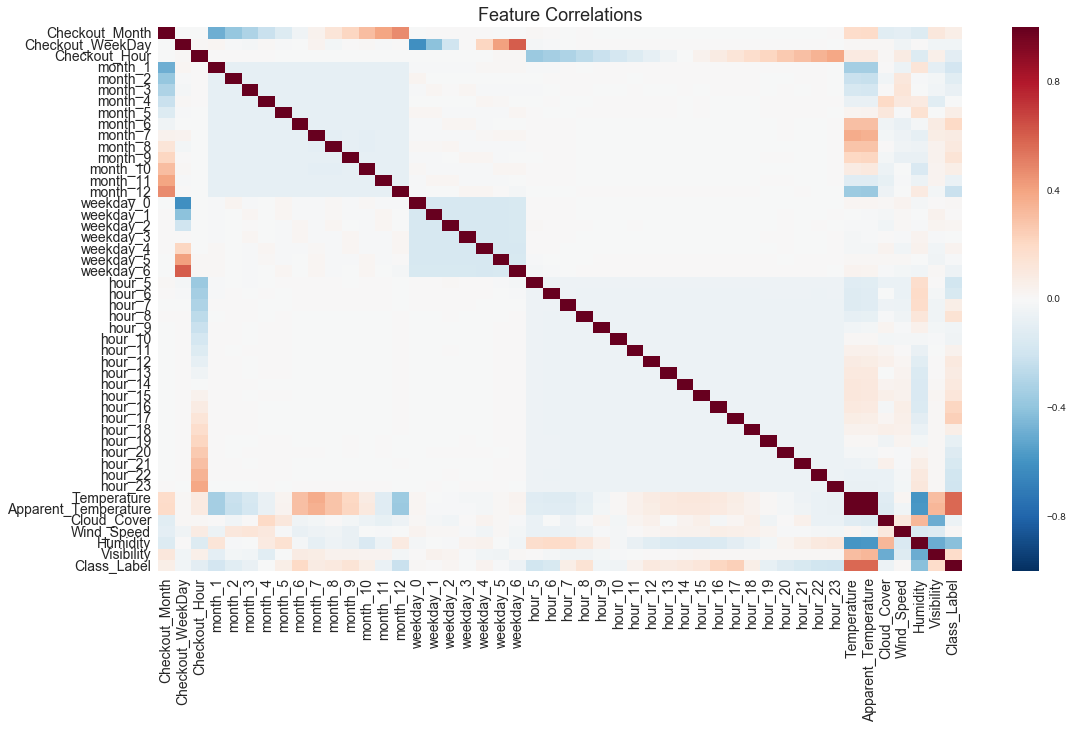

In [41]:
plt.figure(figsize=(18,10))
ax = sns.heatmap(data.corr())
plt.title("Feature Correlations", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [42]:
features = ['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
             'month_9', 'month_10', 'month_11', 'month_12',
             'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
             'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
             'hour_14', 'hour_15', 'hour_16', 'hour_17',
             'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
             'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
X = data[features]
y = data["Class_Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

## 2. Modeling - Categorical Feature Set

In [43]:
def plot_feature_importances(model, plot_title):
    n_features = X.shape[1]
    plt.figure(figsize=(10,14))
    feature_importance = model.feature_importances_
    features_list = features
    feature_importance, features_list = zip(*sorted(zip(feature_importance, features_list)))
    plt.barh(range(len(features_list)), feature_importance, align='center')
    plt.xticks(fontsize=14)
    plt.yticks(np.arange(len(features_list)), features_list, fontsize=14)
    plt.xlabel('Relative Importance', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.title(plot_title + ' Features Importance', fontsize=20)
    plt.show()

In [44]:
def get_class_metrics(model, actual, predicted):
    class_metrics = {'Accuracy' : metrics.accuracy_score(actual, predicted),
                         'F1 (macro)' : metrics.f1_score(actual, predicted, average='macro'),
                         'F1 (micro)' : metrics.f1_score(actual, predicted, average='micro'),
                         'Precision (macro)' : metrics.precision_score(actual, predicted,  average='macro'),
                         'Precision (micro)' : metrics.precision_score(actual, predicted,  average='micro'),
                         'Recall (macro)' : metrics.recall_score(actual, predicted,  average='macro'),
                         'Recall (micro)' : metrics.recall_score(actual, predicted,  average='micro')}
    dML_metrics = pd.DataFrame.from_dict(class_metrics, orient='index')
    dML_metrics.columns = [model]
    return dML_metrics

In [45]:
def perform_classification(model, clfr, features):   
 
    clfr.fit(X_train, y_train)
    ypred = clfr.predict(X_test)
    got_metrics = get_class_metrics(model, y_test, ypred)
    print(model,'\n')
    print("Accuracy on training set: {:.3f}".format(clfr.score(X_train, y_train)))
    print("Accuracy on test set: {:.3f}".format(clfr.score(X_test, y_test)))
    print('\nConfusion Matrix:')
    print(metrics.confusion_matrix(y_test, ypred))
    print('\nClassification Report:')
    print(metrics.classification_report(y_test, ypred))
    return got_metrics, ypred

In [46]:
def perform_cross_validation(clfr):
    shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
    scores = cross_val_score(clfr, X, y, cv=shuffle_split)
    print("Cross-validation scores:\n{}".format(scores))

#### Decision Tree Classification

Decision Tree Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.639

Confusion Matrix:
[[1156  166   35   13    1]
 [ 137  183   97   32    4]
 [  29  105  165   97   11]
 [   9   49   96  188   46]
 [   0    1    9   52   59]]

Classification Report:
             precision    recall  f1-score   support

          0       0.87      0.84      0.86      1371
          1       0.36      0.40      0.38       453
          2       0.41      0.41      0.41       407
          3       0.49      0.48      0.49       388
          4       0.49      0.49      0.49       121

avg / total       0.65      0.64      0.64      2740

Cross-validation scores:
[ 0.63328467  0.6420438   0.63854015  0.62072993  0.63357664  0.63474453
  0.6280292   0.64175182  0.63416058  0.62686131]


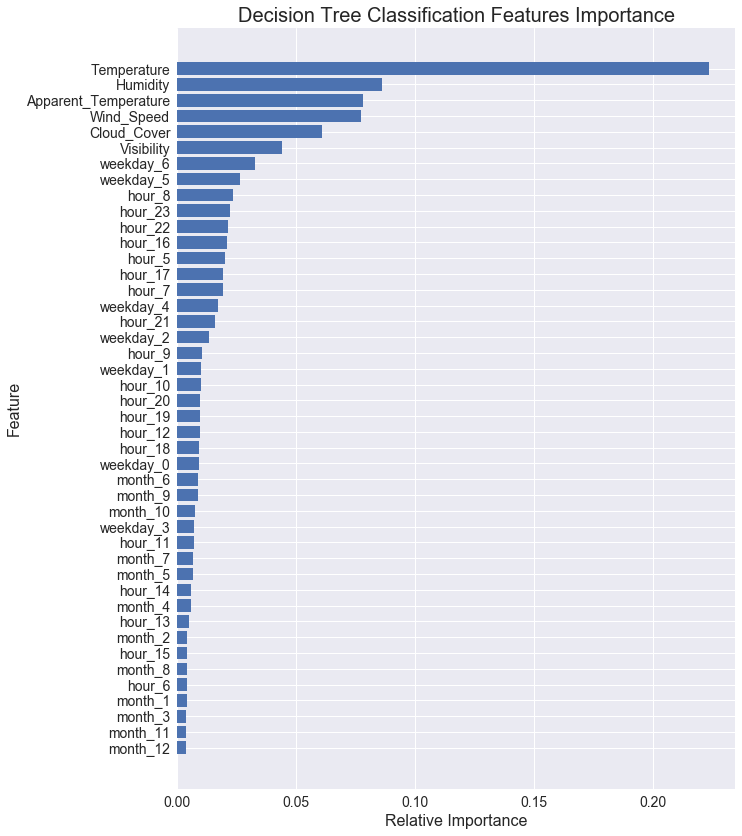

,Decision Tree Classification
Accuracy,0.639051
F1 (macro),0.524387
F1 (micro),0.639051
Precision (macro),0.524363
Precision (micro),0.639051
Recall (macro),0.524940
Recall (micro),0.639051


In [47]:
# Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=0)
dtc, y_pred = perform_classification('Decision Tree Classification', clf, features)
perform_cross_validation(clf)
plot_feature_importances(clf, 'Decision Tree Classification')
dtc.sort_index()

#### Linear (Logistic) Classification

In [48]:
# logistic regression
from sklearn import linear_model
#clf = linear_model.LogisticRegression(random_state=0)
clf = linear_model.LogisticRegression(C=1.0, solver='lbfgs', random_state=0, multi_class='ovr', n_jobs=-1)
lin_reg, y_pred = perform_classification('Logistic Classification', clf, features)
perform_cross_validation(clf)
lin_reg.sort_index()

Logistic Classification 

Accuracy on training set: 0.662
Accuracy on test set: 0.672

Confusion Matrix:
[[1276   44   10   39    2]
 [ 237  116   78   20    2]
 [  66   75  179   83    4]
 [  33   15   82  250    8]
 [   2    0   13   86   20]]

Classification Report:
             precision    recall  f1-score   support

          0       0.79      0.93      0.85      1371
          1       0.46      0.26      0.33       453
          2       0.49      0.44      0.47       407
          3       0.52      0.64      0.58       388
          4       0.56      0.17      0.25       121

avg / total       0.64      0.67      0.64      2740

Cross-validation scores:
[ 0.65430657  0.64759124  0.65051095  0.65051095  0.65372263  0.65751825
  0.66014599  0.65167883  0.64642336  0.65343066]


,Logistic Classification
Accuracy,0.671898
F1 (macro),0.496528
F1 (micro),0.671898
Precision (macro),0.565525
Precision (micro),0.671898
Recall (macro),0.487240
Recall (micro),0.671898


#### Random Forest Classification

Random Forest Classification 

Accuracy on training set: 0.752
Accuracy on test set: 0.661

Confusion Matrix:
[[1298   54    7   12    0]
 [ 232  120   92    9    0]
 [  93   69  190   55    0]
 [  53   33  114  182    6]
 [  13    7   17   63   21]]

Classification Report:
             precision    recall  f1-score   support

          0       0.77      0.95      0.85      1371
          1       0.42      0.26      0.33       453
          2       0.45      0.47      0.46       407
          3       0.57      0.47      0.51       388
          4       0.78      0.17      0.28       121

avg / total       0.64      0.66      0.63      2740

Cross-validation scores:
[ 0.63386861  0.6470073   0.62248175  0.63153285  0.6350365   0.63445255
  0.6379562   0.64262774  0.62978102  0.64321168]


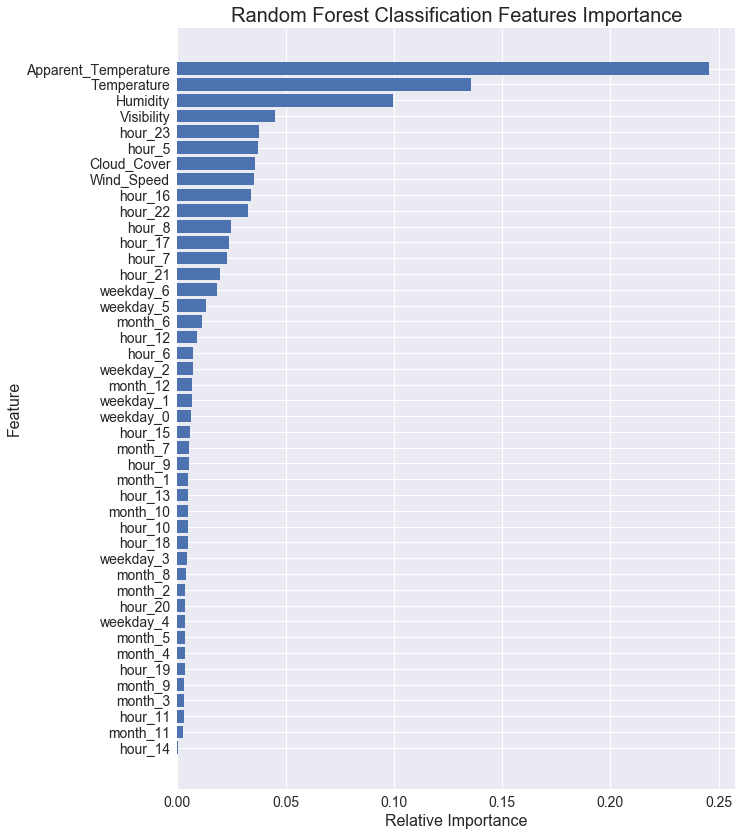

,Random Forest Classification
Accuracy,0.660949
F1 (macro),0.486226
F1 (micro),0.660949
Precision (macro),0.597933
Precision (micro),0.660949
Recall (macro),0.464222
Recall (micro),0.660949


In [49]:
# Random Forest Classifier
#clf = RandomForestClassifier(random_state=0)
clf = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=0, n_jobs=-1)
rfc, y_pred = perform_classification('Random Forest Classification', clf, features)
perform_cross_validation(clf)
plot_feature_importances(clf, 'Random Forest Classification')
rfc.sort_index()

#### Extra Trees Classification

Extra Trees Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.697

Confusion Matrix:
[[1272   80   10    8    1]
 [ 167  185   86   15    0]
 [  38  116  176   74    3]
 [  13   37   91  223   24]
 [   1    3    5   58   54]]

Classification Report:
             precision    recall  f1-score   support

          0       0.85      0.93      0.89      1371
          1       0.44      0.41      0.42       453
          2       0.48      0.43      0.45       407
          3       0.59      0.57      0.58       388
          4       0.66      0.45      0.53       121

avg / total       0.68      0.70      0.69      2740

Cross-validation scores:
[ 0.68583942  0.69576642  0.69810219  0.69021898  0.68963504  0.68992701
  0.68525547  0.68554745  0.69518248  0.67620438]


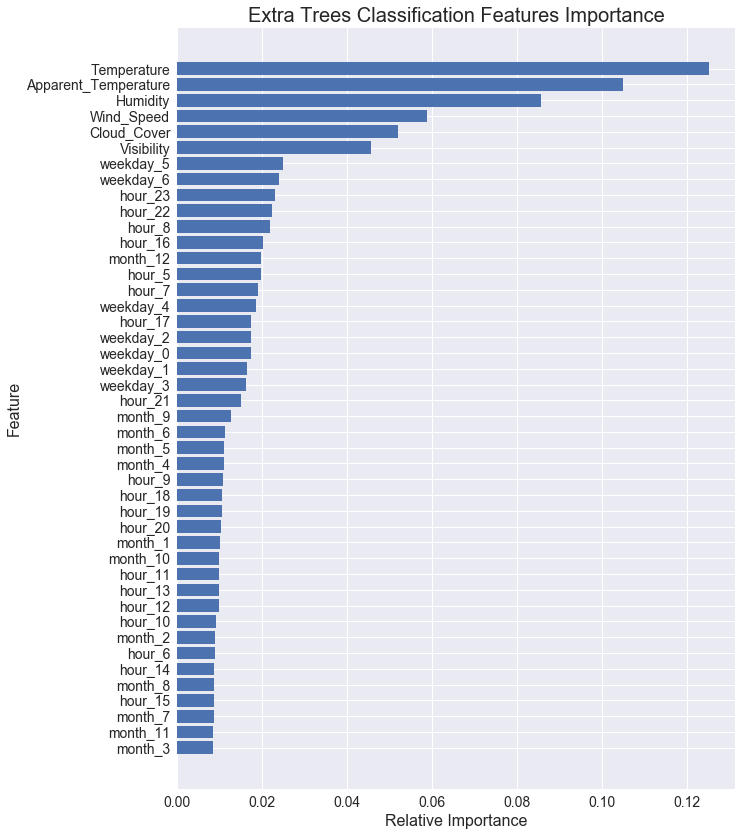

,Extra Trees Classification
Accuracy,0.697080
F1 (macro),0.576138
F1 (micro),0.697080
Precision (macro),0.603859
Precision (micro),0.697080
Recall (macro),0.557927
Recall (micro),0.697080


In [50]:
# Extra Trees Classifier
#clf = ExtraTreesClassifier(random_state=0)
#clf = ExtraTreesClassifier(n_estimators=10, max_depth=10, random_state=0, n_jobs=-1)
clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
etc, y_pred = perform_classification('Extra Trees Classification', clf, features)
perform_cross_validation(clf)
plot_feature_importances(clf, 'Extra Trees Classification')
etc.sort_index()

#### Naive Bayes Classification

In [51]:
# Naive Bayes Classifier
clf = naive_bayes.GaussianNB()
nbg, y_pred = perform_classification('Naive Bayes Classification', clf, features)
perform_cross_validation(clf)
nbg.sort_index()

Naive Bayes Classification 

Accuracy on training set: 0.345
Accuracy on test set: 0.361

Confusion Matrix:
[[613 452 131  45 130]
 [ 24 123 135  38 133]
 [  3  18  86  50 250]
 [  1   8  12  46 321]
 [  0   0   0   1 120]]

Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.45      0.61      1371
          1       0.20      0.27      0.23       453
          2       0.24      0.21      0.22       407
          3       0.26      0.12      0.16       388
          4       0.13      0.99      0.22       121

avg / total       0.59      0.36      0.41      2740

Cross-validation scores:
[ 0.34744526  0.32846715  0.36408759  0.3579562   0.34248175  0.34715328
  0.35912409  0.34744526  0.34364964  0.32437956]


,Naive Bayes Classification
Accuracy,0.360584
F1 (macro),0.290211
F1 (micro),0.360584
Precision (macro),0.355717
Precision (micro),0.360584
Recall (macro),0.408047
Recall (micro),0.360584


#### Nearest Neighbors Classification

In [52]:
# Nearest Neighbors Classifier
clf = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
knn, y_pred = perform_classification('Nearest Neighbors Classification', clf, features)
perform_cross_validation(clf)
knn.sort_index()

Nearest Neighbors Classification 

Accuracy on training set: 0.766
Accuracy on test set: 0.550

Confusion Matrix:
[[1227   97   31   16    0]
 [ 250  110   74   19    0]
 [ 136  136   95   35    5]
 [ 113  105   95   68    7]
 [  29   37   20   29    6]]

Classification Report:
             precision    recall  f1-score   support

          0       0.70      0.89      0.79      1371
          1       0.23      0.24      0.23       453
          2       0.30      0.23      0.26       407
          3       0.41      0.18      0.25       388
          4       0.33      0.05      0.09       121

avg / total       0.50      0.55      0.51      2740

Cross-validation scores:
[ 0.54510949  0.54510949  0.56029197  0.55854015  0.55562044  0.55270073
  0.55591241  0.55153285  0.55532847  0.55182482]


,Nearest Neighbors Classification
Accuracy,0.549635
F1 (macro),0.322821
F1 (micro),0.549635
Precision (macro),0.393611
Precision (micro),0.549635
Recall (macro),0.319211
Recall (micro),0.549635


#### Gradient Boosting Classification

Gradient Boosting Classification 

Accuracy on training set: 0.792
Accuracy on test set: 0.697

Confusion Matrix:
[[1280   66   12    9    4]
 [ 189  164   82   18    0]
 [  38  109  187   70    3]
 [  21   35   75  233   24]
 [   1    0   14   60   46]]

Classification Report:
             precision    recall  f1-score   support

          0       0.84      0.93      0.88      1371
          1       0.44      0.36      0.40       453
          2       0.51      0.46      0.48       407
          3       0.60      0.60      0.60       388
          4       0.60      0.38      0.46       121

avg / total       0.68      0.70      0.68      2740



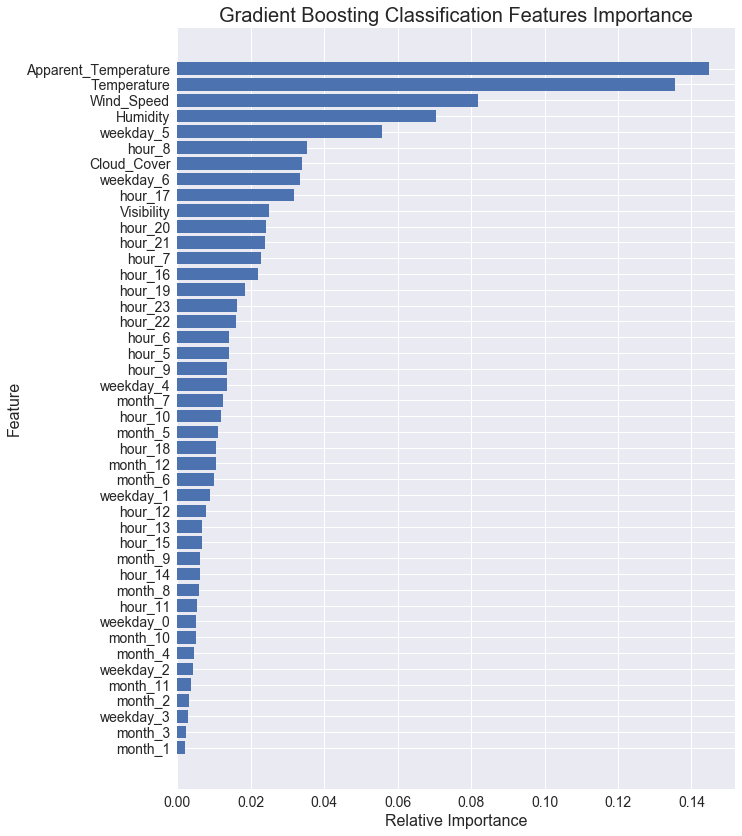

Cross-validation scores:
[ 0.68905109  0.67211679  0.68554745  0.68963504  0.68        0.68350365
  0.68905109  0.68846715  0.67620438  0.69167883]


,Gradient Boosting Classification
Accuracy,0.697080
F1 (macro),0.564866
F1 (micro),0.697080
Precision (macro),0.595179
Precision (micro),0.697080
Recall (macro),0.547159
Recall (micro),0.697080


In [53]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
gbc, y_pred = perform_classification('Gradient Boosting Classification', clf, features)
plot_feature_importances(clf, 'Gradient Boosting Classification')
perform_cross_validation(clf)
gbc.sort_index()

#### Multi-layer Perceptron Classification

In [54]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=0)
mlp, y_pred = perform_classification('Multi-Layer Perceptron Classification', clf, features)
perform_cross_validation(clf)
mlp.sort_index()

Multi-Layer Perceptron Classification 

Accuracy on training set: 0.717
Accuracy on test set: 0.714

Confusion Matrix:
[[1265   67   21   17    1]
 [ 165  165   97   24    2]
 [  23   64  204  109    7]
 [   8   13   65  298    4]
 [   1    0    6   90   24]]

Classification Report:
             precision    recall  f1-score   support

          0       0.87      0.92      0.89      1371
          1       0.53      0.36      0.43       453
          2       0.52      0.50      0.51       407
          3       0.55      0.77      0.64       388
          4       0.63      0.20      0.30       121

avg / total       0.70      0.71      0.70      2740

Cross-validation scores:
[ 0.64846715  0.65605839  0.6519708   0.6610219   0.65372263  0.68291971
  0.64613139  0.66335766  0.6680292   0.63094891]


,Multi-Layer Perceptron Classification
Accuracy,0.713869
F1 (macro),0.556326
F1 (micro),0.713869
Precision (macro),0.620760
Precision (micro),0.713869
Recall (macro),0.550908
Recall (micro),0.713869


## Classification Summary with Categorical Feature Set

In [55]:
# Classifcation Summary
print("Classification Summary with Categorical Features\n")
class_metrics = pd.concat([lin_reg, dtc, rfc, etc, nbg, knn, gbc, mlp] , axis=1)
class_metrics.sort_index()

Classification Summary with Categorical Features



,Logistic Classification,Decision Tree Classification,Random Forest Classification,Extra Trees Classification,Naive Bayes Classification,Nearest Neighbors Classification,Gradient Boosting Classification,Multi-Layer Perceptron Classification
Accuracy,0.671898,0.639051,0.660949,0.697080,0.360584,0.549635,0.697080,0.713869
F1 (macro),0.496528,0.524387,0.486226,0.576138,0.290211,0.322821,0.564866,0.556326
F1 (micro),0.671898,0.639051,0.660949,0.697080,0.360584,0.549635,0.697080,0.713869
Precision (macro),0.565525,0.524363,0.597933,0.603859,0.355717,0.393611,0.595179,0.620760
Precision (micro),0.671898,0.639051,0.660949,0.697080,0.360584,0.549635,0.697080,0.713869
Recall (macro),0.487240,0.524940,0.464222,0.557927,0.408047,0.319211,0.547159,0.550908
Recall (micro),0.671898,0.639051,0.660949,0.697080,0.360584,0.549635,0.697080,0.713869


The multi-layer perceptron model attained the highest accuracy in classifying the four classes. The Naïve Bayes model performed the poorest.

## 3. Modeling - Numeric Feature Set

In [56]:
data = data[['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 
           'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility', 'Class_Label']]

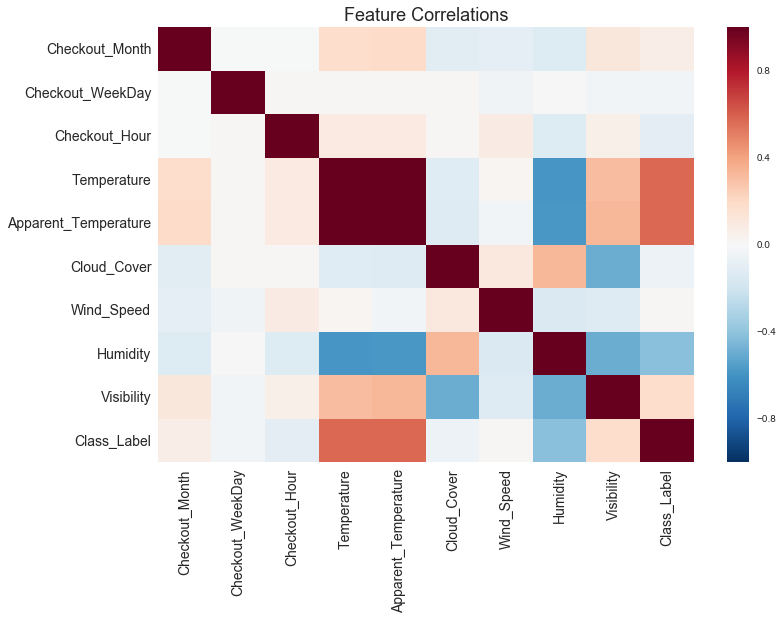

In [57]:
plt.figure(figsize=(12,8))
ax = sns.heatmap(data.corr())
plt.title("Feature Correlations", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6849 entries, 8 to 8783
Data columns (total 10 columns):
Checkout_Month          6849 non-null int32
Checkout_WeekDay        6849 non-null int32
Checkout_Hour           6849 non-null int64
Temperature             6849 non-null float64
Apparent_Temperature    6849 non-null float64
Cloud_Cover             6849 non-null float64
Wind_Speed              6849 non-null float64
Humidity                6849 non-null float64
Visibility              6849 non-null float64
Class_Label             6849 non-null int64
dtypes: float64(6), int32(2), int64(2)
memory usage: 535.1 KB


In [59]:
array = data.values
X = array[:,0:8]
y = array[:,8]

In [60]:
features = ['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',  
            'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
X = data[features]
y = data["Class_Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [61]:
def plot_feature_importances(model, plot_title):
    n_features = X.shape[1]
    plt.figure(figsize=(10,6))
    feature_importance = model.feature_importances_
    features_list = features
    feature_importance, features_list = zip(*sorted(zip(feature_importance, features_list)))
    plt.barh(range(len(features_list)), feature_importance, align='center')
    plt.xticks(fontsize=14)
    plt.yticks(np.arange(len(features_list)), features_list, fontsize=14)
    plt.xlabel('Relative Importance', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.title(plot_title + ' Features Importance', fontsize=20)
    plt.show()

#### Decision Tree Classification

Decision Tree Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.657

Confusion Matrix:
[[1186  148   28    9    0]
 [ 140  168  115   27    3]
 [  22  123  165   94    3]
 [   8   48   81  217   34]
 [   2    2    2   51   64]]

Classification Report:
             precision    recall  f1-score   support

          0       0.87      0.87      0.87      1371
          1       0.34      0.37      0.36       453
          2       0.42      0.41      0.41       407
          3       0.55      0.56      0.55       388
          4       0.62      0.53      0.57       121

avg / total       0.66      0.66      0.66      2740

Cross-validation scores:
[ 0.64905109  0.64554745  0.64642336  0.65051095  0.63824818  0.6470073
  0.63970803  0.64759124  0.63474453  0.65313869]


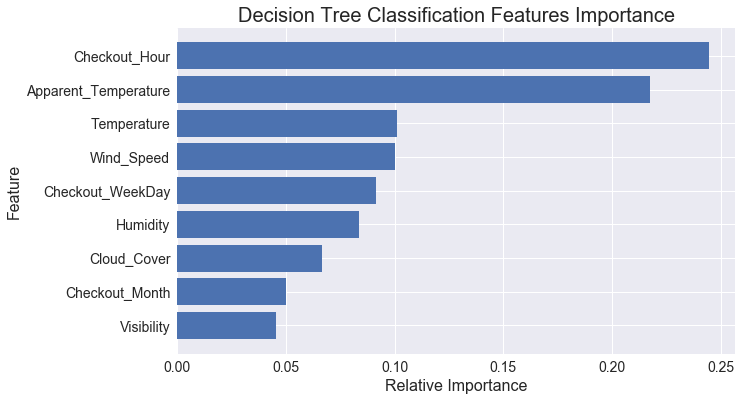

,Decision Tree Classification
Accuracy,0.656934
F1 (macro),0.552091
F1 (micro),0.656934
Precision (macro),0.559901
Precision (micro),0.656934
Recall (macro),0.545906
Recall (micro),0.656934


In [62]:
# Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=0)
dtc, y_pred = perform_classification('Decision Tree Classification', clf, features)
perform_cross_validation(clf)
plot_feature_importances(clf, 'Decision Tree Classification')
dtc.sort_index()

#### Linear (Logistic Regression) Classification

In [63]:
# logistic regression
from sklearn import linear_model
clf = linear_model.LogisticRegression(random_state=0)
lin_reg, y_pred = perform_classification('Logistic Classification', clf, features)
perform_cross_validation(clf)
lin_reg.sort_index()

C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Logistic Classification 

Accuracy on training set: 0.573
Accuracy on test set: 0.577

Confusion Matrix:
[[1280   30   35   26    0]
 [ 266   62   72   53    0]
 [ 143   56  125   83    0]
 [ 133   49   92  114    0]
 [  20   10   40   51    0]]

Classification Report:
             precision    recall  f1-score   support

          0       0.69      0.93      0.80      1371
          1       0.30      0.14      0.19       453
          2       0.34      0.31      0.32       407
          3       0.35      0.29      0.32       388
          4       0.00      0.00      0.00       121

avg / total       0.50      0.58      0.52      2740

Cross-validation scores:
[ 0.5719708   0.57839416  0.56642336  0.54890511  0.57664234  0.57255474
  0.56817518  0.57021898  0.56817518  0.55854015]


,Logistic Classification
Accuracy,0.577007
F1 (macro),0.325555
F1 (micro),0.577007
Precision (macro),0.337289
Precision (micro),0.577007
Recall (macro),0.334286
Recall (micro),0.577007


#### Random Forest Classification

Random Forest Classification 

Accuracy on training set: 0.989
Accuracy on test set: 0.670

Confusion Matrix:
[[1280   71   13    7    0]
 [ 181  163   92   17    0]
 [  39  127  159   81    1]
 [  20   38  102  206   22]
 [   3    3    9   78   28]]

Classification Report:
             precision    recall  f1-score   support

          0       0.84      0.93      0.88      1371
          1       0.41      0.36      0.38       453
          2       0.42      0.39      0.41       407
          3       0.53      0.53      0.53       388
          4       0.55      0.23      0.33       121

avg / total       0.65      0.67      0.66      2740

Cross-validation scores:
[ 0.67094891  0.65810219  0.66569343  0.65343066  0.6729927   0.66131387
  0.66423358  0.66627737  0.6589781   0.65722628]


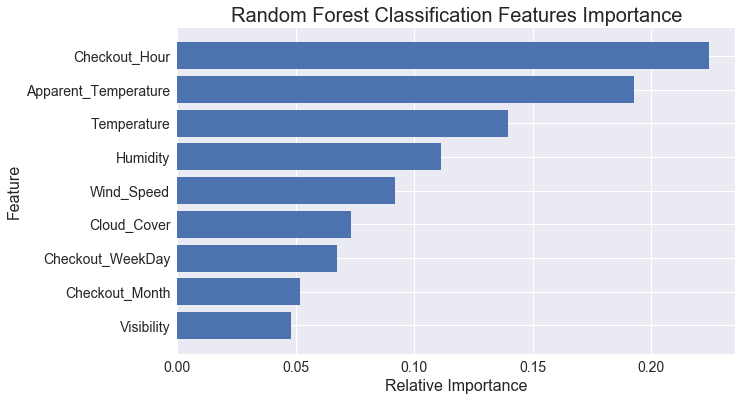

,Random Forest Classification
Accuracy,0.670073
F1 (macro),0.505670
F1 (micro),0.670073
Precision (macro),0.549700
Precision (micro),0.670073
Recall (macro),0.489289
Recall (micro),0.670073


In [64]:
# Random Forest Classifier
clf = RandomForestClassifier(random_state=0)
rfc, y_pred = perform_classification('Random Forest Classification', clf, features)
perform_cross_validation(clf)
plot_feature_importances(clf, 'Random Forest Classification')
rfc.sort_index()

#### Extra Trees Classification

Extra Trees Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.665

Confusion Matrix:
[[1284   61   18    7    1]
 [ 182  163   90   18    0]
 [  58  116  153   79    1]
 [  31   44  103  189   21]
 [   4    7    8   68   34]]

Classification Report:
             precision    recall  f1-score   support

          0       0.82      0.94      0.88      1371
          1       0.42      0.36      0.39       453
          2       0.41      0.38      0.39       407
          3       0.52      0.49      0.50       388
          4       0.60      0.28      0.38       121

avg / total       0.64      0.67      0.65      2740

Cross-validation scores:
[ 0.66014599  0.66569343  0.64175182  0.66481752  0.66014599  0.66656934
  0.66715328  0.65547445  0.67211679  0.64905109]


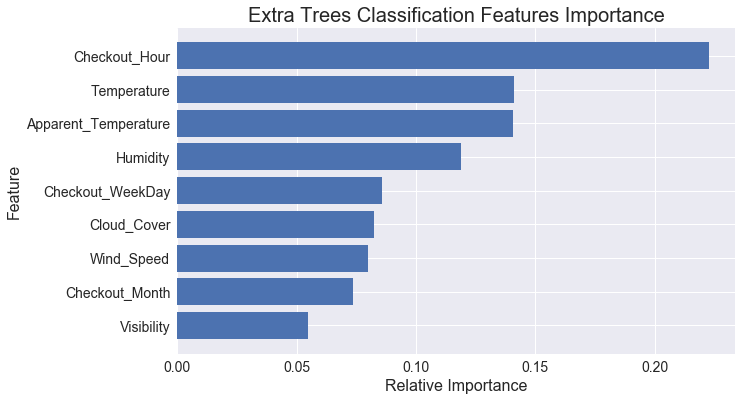

,Extra Trees Classification
Accuracy,0.665328
F1 (macro),0.508443
F1 (micro),0.665328
Precision (macro),0.554362
Precision (micro),0.665328
Recall (macro),0.488079
Recall (micro),0.665328


In [65]:
# Extra Trees Classifier
clf = ExtraTreesClassifier(random_state=0)
etc, y_pred = perform_classification('Extra Trees Classification', clf, features)
perform_cross_validation(clf)
plot_feature_importances(clf, 'Extra Trees Classification')
etc.sort_index()

#### Naive Bayes Classification

In [66]:
# Naive Bayes Classifier
clf = naive_bayes.GaussianNB()
nbg, y_pred = perform_classification('Naive Bayes Classification', clf, features)
perform_cross_validation(clf)
nbg.sort_index()

Naive Bayes Classification 

Accuracy on training set: 0.492
Accuracy on test set: 0.500

Confusion Matrix:
[[973 147   1 248   2]
 [111  89   8 244   1]
 [ 46  54   7 293   7]
 [ 32  47   8 295   6]
 [  2   6   0 106   7]]

Classification Report:
             precision    recall  f1-score   support

          0       0.84      0.71      0.77      1371
          1       0.26      0.20      0.22       453
          2       0.29      0.02      0.03       407
          3       0.25      0.76      0.37       388
          4       0.30      0.06      0.10       121

avg / total       0.55      0.50      0.48      2740

Cross-validation scores:
[ 0.47854015  0.47532847  0.48788321  0.4729927   0.49226277  0.47766423
  0.49343066  0.48175182  0.4540146   0.49489051]


,Naive Bayes Classification
Accuracy,0.500365
F1 (macro),0.299163
F1 (micro),0.500365
Precision (macro),0.388027
Precision (micro),0.500365
Recall (macro),0.348306
Recall (micro),0.500365


#### Nearest Neighbors Classification

In [67]:
# Nearest Neighbors Classifier
clf = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
knn, y_pred = perform_classification('Nearest Neighbors Classification', clf, features)
perform_cross_validation(clf)
knn.sort_index()

Nearest Neighbors Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.590

Confusion Matrix:
[[1125  154   64   26    2]
 [ 151  139  102   55    6]
 [  57   94  154   87   15]
 [  23   57   98  161   49]
 [   5   12   16   51   37]]

Classification Report:
             precision    recall  f1-score   support

          0       0.83      0.82      0.82      1371
          1       0.30      0.31      0.31       453
          2       0.35      0.38      0.37       407
          3       0.42      0.41      0.42       388
          4       0.34      0.31      0.32       121

avg / total       0.59      0.59      0.59      2740

Cross-validation scores:
[ 0.58072993  0.58394161  0.57605839  0.58189781  0.58510949  0.58948905
  0.57693431  0.59532847  0.58189781  0.59386861]


,Nearest Neighbors Classification
Accuracy,0.589781
F1 (macro),0.447329
F1 (micro),0.589781
Precision (macro),0.449879
Precision (micro),0.589781
Recall (macro),0.445305
Recall (micro),0.589781


#### Gradient Boosting Classification

Gradient Boosting Classification 

Accuracy on training set: 0.789
Accuracy on test set: 0.702

Confusion Matrix:
[[1293   59   14    4    1]
 [ 183  166   88   16    0]
 [  26  118  170   92    1]
 [   8   41   78  247   14]
 [   1    3    6   64   47]]

Classification Report:
             precision    recall  f1-score   support

          0       0.86      0.94      0.90      1371
          1       0.43      0.37      0.40       453
          2       0.48      0.42      0.45       407
          3       0.58      0.64      0.61       388
          4       0.75      0.39      0.51       121

avg / total       0.69      0.70      0.69      2740



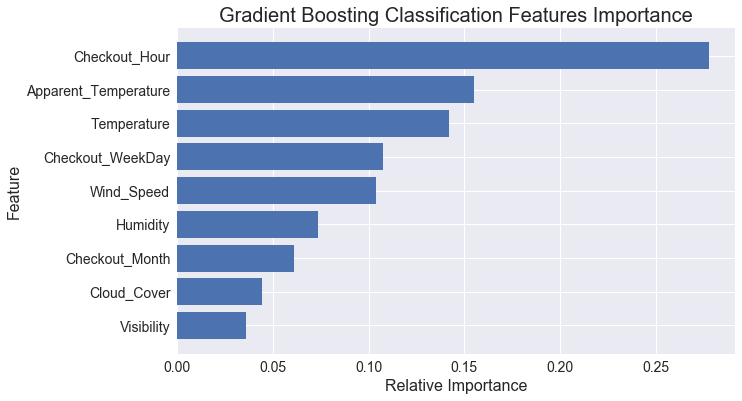

Cross-validation scores:
[ 0.70335766  0.69751825  0.69167883  0.68788321  0.68233577  0.70569343
  0.69518248  0.6919708   0.69459854  0.69051095]


,Gradient Boosting Classification
Accuracy,0.701825
F1 (macro),0.571627
F1 (micro),0.701825
Precision (macro),0.618430
Precision (micro),0.701825
Recall (macro),0.550454
Recall (micro),0.701825


In [68]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
gbc, y_pred = perform_classification('Gradient Boosting Classification', clf, features)
plot_feature_importances(clf, 'Gradient Boosting Classification')
perform_cross_validation(clf)
gbc.sort_index()

#### Multi-layer Perceptron Classification

In [69]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=0)
mlp, y_pred = perform_classification('Multi-Layer Perceptron Classification', clf, features)
perform_cross_validation(clf)
mlp.sort_index()

C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Multi-Layer Perceptron Classification 

Accuracy on training set: 0.599
Accuracy on test set: 0.607

Confusion Matrix:
[[1284   11   59   17    0]
 [ 217    9  190   37    0]
 [  77    1  271   58    0]
 [  74    5  211   98    0]
 [  10    0   81   30    0]]

Classification Report:
             precision    recall  f1-score   support

          0       0.77      0.94      0.85      1371
          1       0.35      0.02      0.04       453
          2       0.33      0.67      0.44       407
          3       0.41      0.25      0.31       388
          4       0.00      0.00      0.00       121

avg / total       0.55      0.61      0.54      2740

Cross-validation scores:
[ 0.60291971  0.57985401  0.59240876  0.57751825  0.55182482  0.57635036
  0.56525547  0.57547445  0.57927007  0.59036496]


,Multi-Layer Perceptron Classification
Accuracy,0.606569
F1 (macro),0.328199
F1 (micro),0.606569
Precision (macro),0.372159
Precision (micro),0.606569
Recall (macro),0.374967
Recall (micro),0.606569


## Classification Summary with Numeric Feature Set

In [70]:
# Classifcation Summary
print("Classification Summary with Numeric Feature Set\n")
class_metrics = pd.concat([lin_reg, dtc, rfc, etc, nbg, knn, gbc, mlp] , axis=1)
class_metrics.sort_index()

Classification Summary with Numeric Feature Set



,Logistic Classification,Decision Tree Classification,Random Forest Classification,Extra Trees Classification,Naive Bayes Classification,Nearest Neighbors Classification,Gradient Boosting Classification,Multi-Layer Perceptron Classification
Accuracy,0.577007,0.656934,0.670073,0.665328,0.500365,0.589781,0.701825,0.606569
F1 (macro),0.325555,0.552091,0.505670,0.508443,0.299163,0.447329,0.571627,0.328199
F1 (micro),0.577007,0.656934,0.670073,0.665328,0.500365,0.589781,0.701825,0.606569
Precision (macro),0.337289,0.559901,0.549700,0.554362,0.388027,0.449879,0.618430,0.372159
Precision (micro),0.577007,0.656934,0.670073,0.665328,0.500365,0.589781,0.701825,0.606569
Recall (macro),0.334286,0.545906,0.489289,0.488079,0.348306,0.445305,0.550454,0.374967
Recall (micro),0.577007,0.656934,0.670073,0.665328,0.500365,0.589781,0.701825,0.606569


## 4. Summary

The Gradient Boosting Classifier achieved the highest accuracy and the Naïve Bayes the lowest. While the Multi-Layer Perceptron model had better accuracy than the Gradient Boosting with the categorical feature set it did not fare as well with the numerical feature set.